In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
market_caps = pd.read_csv("data/new/market_caps.csv")
prices = pd.read_csv("data/new/prices.csv")
volumes = pd.read_csv("data/new/volumes.csv")
coins = list(pd.read_csv("data/new/coins.csv")['coins'].values)

stable_coins = ['tether', 'usd-coin', 'dai', 'binance-usd']
for c in stable_coins:
    try:
        coins.remove(c)
    except:
        pass

In [3]:
prices.head()

,date,bitcoin_price,ethereum_price,tether_price,usd-coin_price,binancecoin_price,ripple_price,binance-usd_price,cardano_price,dogecoin_price,...,gods-unchained_price,cult-dao_price,snowbank_price,gamefi_price,litentry_price,rootkit_price,refinable_price,tellor_price,verus-coin_price,gas_price
0,2018-01-01,14093.606831,776.080330,1.008910,NaN,8.828099,2.31012,NaN,0.747140,0.009091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.038398
1,2018-01-02,15321.932852,876.890259,1.003920,NaN,9.090393,2.45529,NaN,0.807430,0.009335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.866662
2,2018-01-03,15583.885538,963.055751,1.015780,NaN,9.886323,3.12571,NaN,1.075401,0.009592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.747737
3,2018-01-04,15976.365194,978.416104,1.002740,NaN,9.675758,3.22005,NaN,1.179347,0.010098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.379504
4,2018-01-05,18336.922980,1004.894972,0.999695,NaN,16.488523,2.93138,NaN,1.077821,0.013841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.218385


In [4]:
#rebalance portfolio of coins given target allocations, rebalance period, and start and end dates
def period_rebalance(coins, ps, period=42, allocations="equal", starting=1000000, from_date="2018-01-01", to_date="2023-01-15"):
    n = len(coins)
    
    if allocations=='equal':
        weights = dict(zip(coins, n*[1./n]))
    else:
        weights = allocations
    
    prices = ps.loc[(ps['date']>=from_date) & (ps['date']<=to_date)]
    prices.reset_index(inplace=True)
    
    dates = prices['date'].to_numpy()
    days = len(dates)
    
    rebalance_df = pd.DataFrame({'date':dates})
    rebalance_df['portfolio_value'] = pd.Series(dtype='float64')
    for coin in coins:
        rebalance_df[coin+'_percent'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_value'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_amount'] = pd.Series(dtype='float64')
        
    rebalance_df.at[0, 'portfolio_value'] = starting
    for coin in coins: 
        rebalance_df.at[0, coin+'_percent'] = 100*weights[coin]
        rebalance_df.at[0, coin+'_value'] = starting*weights[coin]
        rebalance_df.at[0, coin+'_amount'] = starting*weights[coin]/prices.loc[0,coin+'_price']
        
    for i in range(1,days):
        new_total = 0
        for coin in coins:
            coin_amount = rebalance_df.loc[i-1, coin+'_amount']
            
            j=0
            while True:
                new_price = prices.loc[i-j, coin+'_price']
                if np.isnan(new_price):
                    j += 1
                else:
                    break
            
            new_value = new_price*coin_amount
            rebalance_df.at[i, coin+'_value'] = new_value
            rebalance_df.at[i, coin+'_amount'] = coin_amount
            new_total += new_value
            
        rebalance_df.at[i, 'portfolio_value'] = new_total
        for coin in coins:
            new_coin_percent = rebalance_df.loc[i, coin+'_value']/new_total * 100
            rebalance_df.at[i, coin+'_percent'] = new_coin_percent
            
        
        if i%period == 0:
            for coin in coins:
                new_value = weights[coin]*rebalance_df.loc[i, 'portfolio_value']
                
                j=0
                while True:
                    new_price = prices.loc[i-j, coin+'_price']
                    if np.isnan(new_price):
                        j += 1
                    else:
                        break
                    
                new_amount = new_value/new_price
                new_percent = 100*weights[coin]
                
                rebalance_df.at[i, coin+'_percent'] = new_percent
                rebalance_df.at[i, coin+'_value'] = new_value
                rebalance_df.at[i, coin+'_amount'] = new_amount
        
        
    return rebalance_df

#rebalance top n coins (by current market cap) over a time period when data exists for all coins
def top_n_period_rebalance(n, coins_all, ps, period=42, allocations="equal", starting=1000000, from_date=None, to_date=None):
    coins = coins_all[:n]
    
    not_null = ~prices[coins[0]+"_price"].isna()
    for coin in coins[1:]:
        not_null = not_null & ~prices[coin+"_price"].isna()
        
    dates = ps[not_null]["date"]
    
    fd = dates.iloc[0]
    td = dates.iloc[-1]
    if from_date != None:
        fd = max(from_date, fd)
    if to_date != None:
        td = min(to_date, td)
        
    return period_rebalance(coins, ps, period=period, allocations=allocations, starting=starting, from_date=fd, to_date=td)

In [5]:
#rebalance portfolio of coins given target allocations, rebalance period, and start and end dates
def threshold_rebalance(coins, ps, threshold=10, allocations="equal", starting=1000000, from_date="2018-01-01", to_date="2023-01-15"):
    n = len(coins)
    
    if allocations=='equal':
        weights = dict(zip(coins, n*[1./n]))
    else:
        weights = allocations
    
    prices = ps.loc[(ps['date']>=from_date) & (ps['date']<=to_date)]
    prices.reset_index(inplace=True)
    
    dates = prices['date'].to_numpy()
    days = len(dates)
    
    rebalance_df = pd.DataFrame({'date':dates})
    rebalance_df['portfolio_value'] = pd.Series(dtype='float64')
    for coin in coins:
        rebalance_df[coin+'_percent'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_value'] = pd.Series(dtype='float64')
        rebalance_df[coin+'_amount'] = pd.Series(dtype='float64')
        
    rebalance_df.at[0, 'portfolio_value'] = starting
    for coin in coins: 
        rebalance_df.at[0, coin+'_percent'] = 100*weights[coin]
        rebalance_df.at[0, coin+'_value'] = starting*weights[coin]
        rebalance_df.at[0, coin+'_amount'] = starting*weights[coin]/prices.loc[0,coin+'_price']
        
    for i in range(1,days):
        new_total = 0
        for coin in coins:
            coin_amount = rebalance_df.loc[i-1, coin+'_amount']
            
            j=0
            while True:
                new_price = prices.loc[i-j, coin+'_price']
                if np.isnan(new_price):
                    j += 1
                else:
                    break
            
            new_value = new_price*coin_amount
            rebalance_df.at[i, coin+'_value'] = new_value
            rebalance_df.at[i, coin+'_amount'] = coin_amount
            new_total += new_value
            
        rebalance_df.at[i, 'portfolio_value'] = new_total
        for coin in coins:
            new_coin_percent = rebalance_df.loc[i, coin+'_value']/new_total * 100
            rebalance_df.at[i, coin+'_percent'] = new_coin_percent
            
        threshold_passed = False
        
        for coin in coins:
            if rebalance_df.at[i, coin+'_percent']/(100*weights[coin]) < 1-threshold/100:
                threshold_passed=True
            if rebalance_df.at[i, coin+'_percent']/(100*weights[coin]) > 1+threshold/100:
                threshold_passed=True
            
        if threshold_passed:
            for coin in coins:
                new_value = weights[coin]*rebalance_df.loc[i, 'portfolio_value']
                
                j=0
                while True:
                    new_price = prices.loc[i-j, coin+'_price']
                    if np.isnan(new_price):
                        j += 1
                    else:
                        break
                    
                new_amount = new_value/new_price
                new_percent = 100*weights[coin]
                
                rebalance_df.at[i, coin+'_percent'] = new_percent
                rebalance_df.at[i, coin+'_value'] = new_value
                rebalance_df.at[i, coin+'_amount'] = new_amount
        
        
    return rebalance_df

#rebalance top n coins (by current market cap) over a time period when data exists for all coins
def top_n_threshold_rebalance(n, coins_all, ps, threshold=10, allocations="equal", starting=1000000, from_date=None, to_date=None):
    coins = coins_all[:n]
    
    not_null = ~prices[coins[0]+"_price"].isna()
    for coin in coins[1:]:
        not_null = not_null & ~prices[coin+"_price"].isna()
        
    dates = ps[not_null]["date"]
    
    fd = dates.iloc[0]
    td = dates.iloc[-1]
    if from_date != None:
        fd = max(from_date, fd)
    if to_date != None:
        td = min(to_date, td)
        
    return threshold_rebalance(coins, ps, threshold=threshold, allocations=allocations, starting=starting, from_date=fd, to_date=td)

In [6]:
#buy and hold of coins given target allocations and start and end dates
def buy_and_hold(coins, ps, allocations="equal", starting=1000000, from_date="2018-01-01", to_date="2023-01-15"):
    n = len(coins)
    
    if allocations=='equal':
        weights = dict(zip(coins, n*[1./n]))
    else:
        weights = allocations
    
    prices = ps.loc[(ps['date']>=from_date) & (ps['date']<=to_date)]
    prices.reset_index(inplace=True)
    
    dates = prices['date'].to_numpy()
    days = len(dates)
    
    df = pd.DataFrame({'date':dates})
    df['portfolio_value'] = pd.Series(dtype='float64')
    for coin in coins:
        df[coin+'_percent'] = pd.Series(dtype='float64')
        df[coin+'_value'] = pd.Series(dtype='float64')
        df[coin+'_amount'] = pd.Series(dtype='float64')
        
    df.at[0, 'portfolio_value'] = starting
    for coin in coins: 
        df.at[0, coin+'_percent'] = 100*weights[coin]
        df.at[0, coin+'_value'] = starting*weights[coin]
        df.at[0, coin+'_amount'] = starting*weights[coin]/prices.loc[0,coin+'_price']
        
    for i in range(1,days):
        new_total = 0
        for coin in coins:
            coin_amount = df.loc[i-1, coin+'_amount']
            
            j=0
            while True:
                new_price = prices.loc[i-j, coin+'_price']
                if np.isnan(new_price):
                    j += 1
                else:
                    break
                    
            new_value = new_price*coin_amount
            df.at[i, coin+'_value'] = new_value
            df.at[i, coin+'_amount'] = coin_amount
            new_total += new_value
            
        df.at[i, 'portfolio_value'] = new_total
        for coin in coins:
            new_coin_percent = df.loc[i, coin+'_value']/new_total * 100
            df.at[i, coin+'_percent'] = new_coin_percent
        
    return df

#buy and hold of top n coins (by current market cap) over a time period when data exists for all coins
def top_n_buy_and_hold(n, coins_all, ps, allocations="equal", starting=1000000, from_date=None, to_date=None):
    coins = coins_all[:n]
    
    not_null = ~prices[coins[0]+"_price"].isna()
    for coin in coins[1:]:
        not_null = not_null & ~prices[coin+"_price"].isna()
        
    dates = ps[not_null]["date"]
    
    fd = dates.iloc[0]
    td = dates.iloc[-1]
    if from_date != None:
        fd = max(from_date, fd)
    if to_date != None:
        td = min(to_date, td)
        
    return buy_and_hold(coins, ps, allocations=allocations, starting=starting, from_date=fd, to_date=td)

In [7]:
def top_10_portfolio_plot(coins, prices, period=30, threshold=15, from_date="2018-01-01", to_date="2023-01-15"):
    fig, ax = plt.subplots(3, 1, figsize=(20,22), sharex=True)
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    plt.subplots_adjust(wspace=0, hspace=0)
    
    df_period = top_n_period_rebalance(10, coins, prices, period=period, from_date=from_date, to_date=to_date)
    df_thresh = top_n_threshold_rebalance(10, coins, prices, threshold=threshold, from_date=from_date, to_date=to_date)
    dfbh = top_n_buy_and_hold(10, coins, prices, from_date=from_date, to_date=to_date)

    n = df_period.shape[0]
    ax1.plot(df_period['date'].values, prices['bitcoin_price'][-n:].values/prices['bitcoin_price'][-n:].values[0], label='btc')
    ax1.plot(prices['ethereum_price'][-n:].values/prices['ethereum_price'][-n:].values[0], label='eth')
    ax1.plot(df_period["portfolio_value"].values/df_period["portfolio_value"].values[0], label='periodic')
    ax1.plot(dfbh["portfolio_value"].values/dfbh["portfolio_value"].values[0], label='bandh')
    ax1.plot(df_thresh["portfolio_value"].values/df_thresh["portfolio_value"].values[0], label='thresh')
    ax1.xaxis.set_ticks(np.arange(0,n,max(period,30)))
    maxy=ax1.get_ylim()[1]
    ax1.yaxis.set_ticks(np.arange(0,maxy+0.1,maxy/10.))
    ax1.set_ylim(ymin=0)
    ax1.grid(True, color='k', linestyle='-')
    ax1.legend()

    allocations = df_period[[c+'_percent' for c in coins[:10]]].values.T
    ax2.xaxis.set_ticks(np.arange(0,n,max(period,30)))
    ax2.yaxis.set_ticks(np.arange(0,110,10))
    ax2.grid(True, color='k', linestyle='-')
    ax2.stackplot(df_period['date'].values, allocations[0], allocations[1], allocations[2], allocations[3], allocations[4], allocations[5], allocations[6], allocations[7], allocations[8], allocations[9], labels=coins[:10])
    ax2.set_ylim(ymax=100)
    plt.xticks(rotation=90)
    ax2.legend()
    
    allocations = df_thresh[[c+'_percent' for c in coins[:10]]].values.T
    ax3.xaxis.set_ticks(np.arange(0,n,max(period,30)))
    ax3.yaxis.set_ticks(np.arange(0,110,10))
    ax3.grid(True, color='k', linestyle='-')
    ax3.stackplot(df_thresh['date'].values, allocations[0], allocations[1], allocations[2], allocations[3], allocations[4], allocations[5], allocations[6], allocations[7], allocations[8], allocations[9], labels=coins[:10])
    ax3.set_ylim(ymax=100)
    ax3.legend()

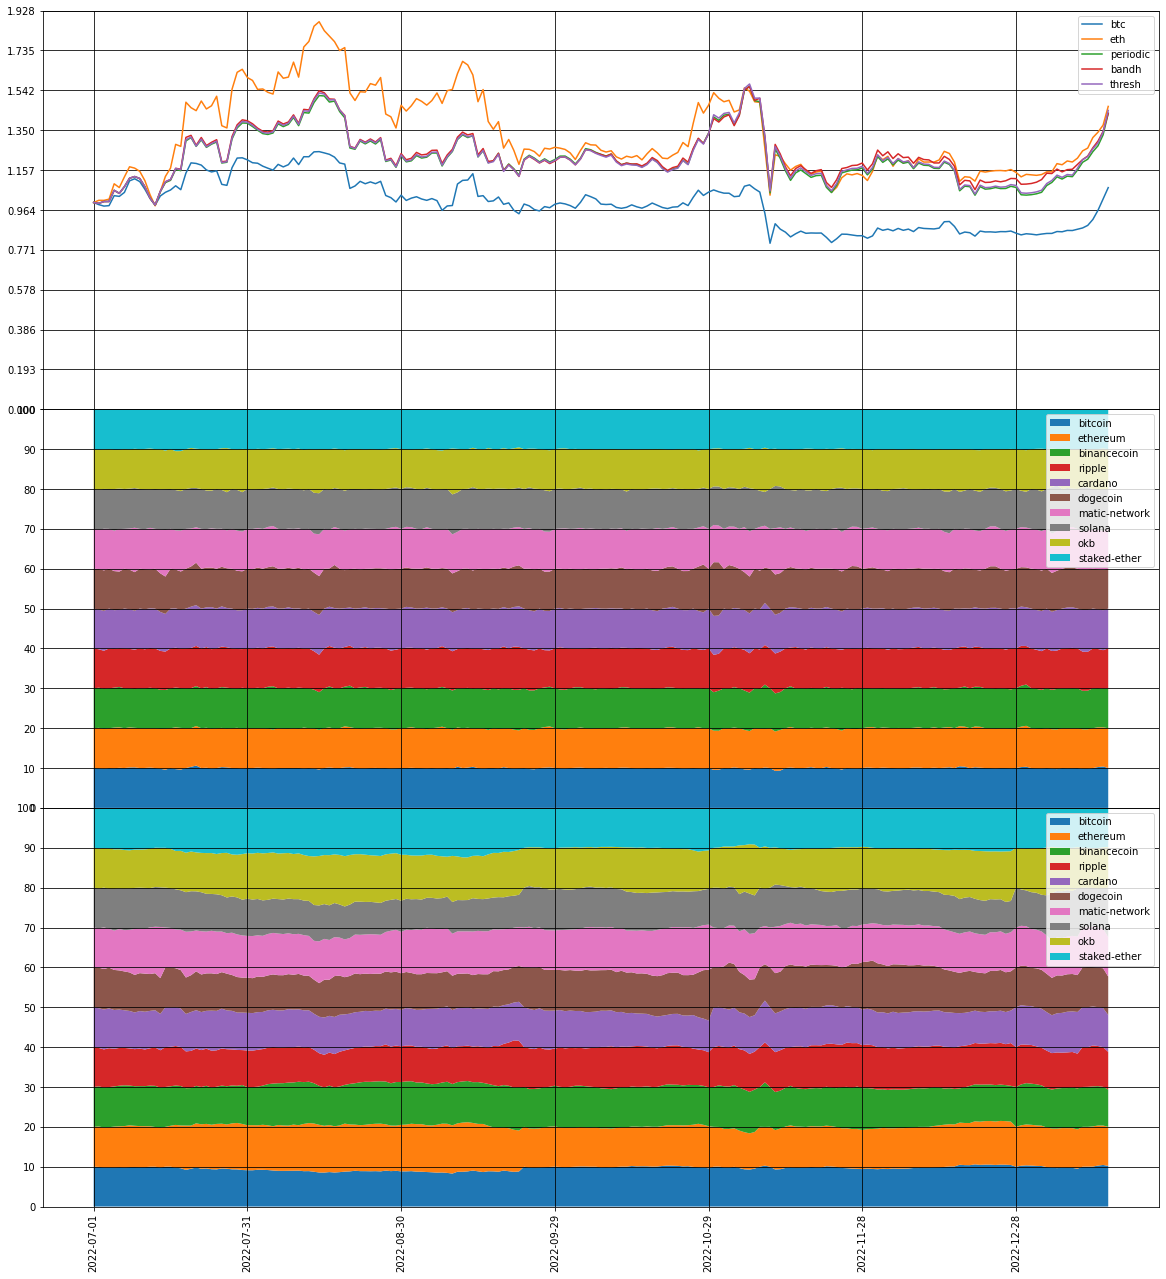

In [8]:
top_10_portfolio_plot(coins, prices, period=3, threshold=30, from_date="2022-07-01")

In [9]:
def first_not_nan(array):
    for x in array:
        if not np.isnan(x):
            return x

In [10]:
def log_top_n_prices(n, coins, prices):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    for i in range(0,n):
        series = prices[coins[i]+"_price"].values*1/first_not_nan(prices[coins[i]+"_price"].values)
        series = np.log10(series)
        plt.plot(prices['date'], series, label=coins[i]+"_price")

    ax.xaxis.set_ticks(np.arange(0,1840,100))
    ax.yaxis.set_ticks(np.arange(-2,7,1))
    ax.grid(True)

    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

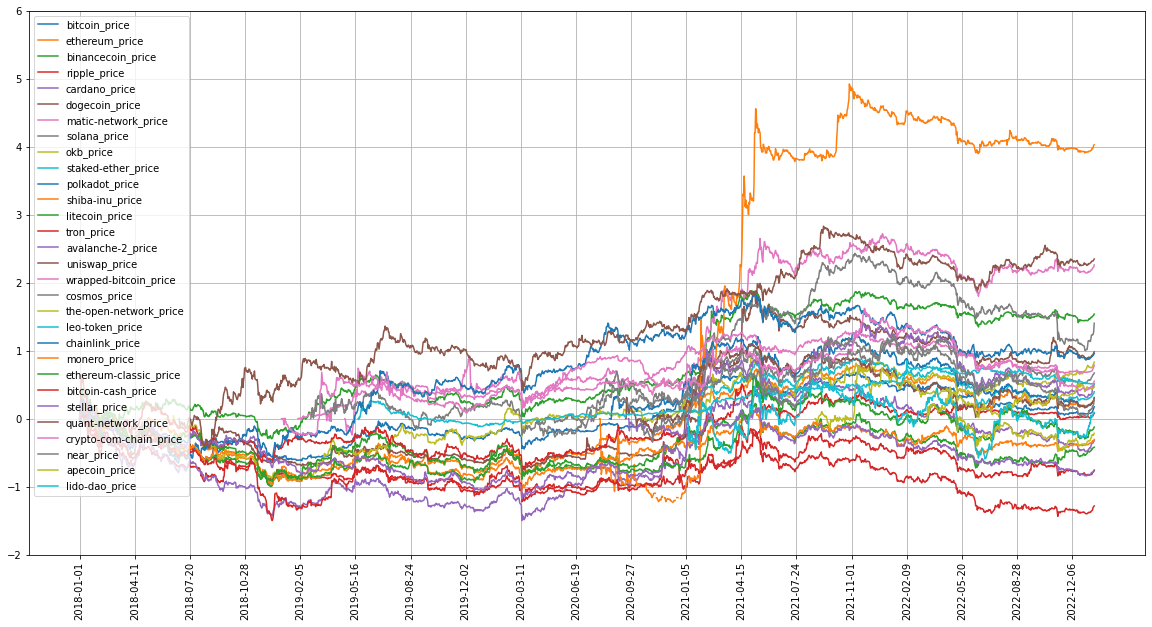

In [11]:
log_top_n_prices(30, coins, prices)

In [12]:
def periodic_rebalance_returns_table(num_coins, periods, coins_all, prices, from_date='2022-01-01', to_date='2023-01-01'):
    returns = []
    for n in num_coins:
        for p in periods:
            df_new = top_n_period_rebalance(n, coins, prices, p, from_date=from_date, to_date=to_date)
            returns.append([n,p,100*df_new['portfolio_value'].iloc[-1]/df_new['portfolio_value'].iloc[0]-100])
            
    returnsdf = pd.DataFrame(returns, columns=['num_coins', 'period', 'return'])
    returnsdf = returnsdf.pivot_table(index=['num_coins'], columns=['period'], values='return')
    
    return returnsdf

def threshold_rebalance_returns_table(num_coins, thresholds, coins_all, prices, from_date='2022-01-01', to_date='2023-01-01'):
    returns = []
    for n in num_coins:
        for t in thresholds:
            df_new = top_n_threshold_rebalance(n, coins, prices, threshold=t, from_date=from_date, to_date=to_date)
            returns.append([n,t,100*df_new['portfolio_value'].iloc[-1]/df_new['portfolio_value'].iloc[0]-100])
            
    returnsdf = pd.DataFrame(returns, columns=['num_coins', 'threshold', 'return'])
    returnsdf = returnsdf.pivot_table(index=['num_coins'], columns=['threshold'], values='return')
    
    return returnsdf

def bandh_returns_table(num_coins, coins_all, prices, from_date='2022-01-01', to_date='2023-01-01'):
    returns = []
    for n in num_coins:
        df_new = top_n_buy_and_hold(n, coins, prices, from_date=from_date, to_date=to_date)
        returns.append([n,100*df_new['portfolio_value'].iloc[-1]/df_new['portfolio_value'].iloc[0]-100])
            
    returnsdf = pd.DataFrame(returns, columns=['num_coins', 'return'])
    returnsdf = returnsdf.set_index('num_coins')
    
    return returnsdf

def return_heatmaps(num_coins, periods, thresholds, coins_all, prices, from_date='2022-01-01', to_date='2023-01-01'):
    returnsdf_period = periodic_rebalance_returns_table(num_coins, periods, coins_all, prices, from_date=from_date, to_date=to_date)
    returnsdf_threshold = threshold_rebalance_returns_table(num_coins, thresholds, coins_all, prices, from_date=from_date, to_date=to_date)
    returnsdf_bandh = bandh_returns_table(num_coins, coins_all, prices, from_date=from_date, to_date=to_date)
    fig, axes = plt.subplots(2,2,figsize=(15,10))
    sns.heatmap(returnsdf_period.astype(int), annot=True, fmt='', ax=axes[0, 0])
    axes[0, 0].set_title(f"Periodic rebalance returns from {from_date} to {to_date}")
    sns.heatmap(returnsdf_threshold.astype(int), annot=True, fmt='', ax=axes[0, 1])
    axes[0, 1].set_title(f"Threshold rebalance returns from {from_date} to {to_date}")
    sns.heatmap(returnsdf_bandh.astype(int), annot=True, fmt='', ax=axes[1, 0])
    axes[1, 0].set_title(f"Buy and Hold returns from {from_date} to {to_date}")
    axes[1, 1].axis('off')

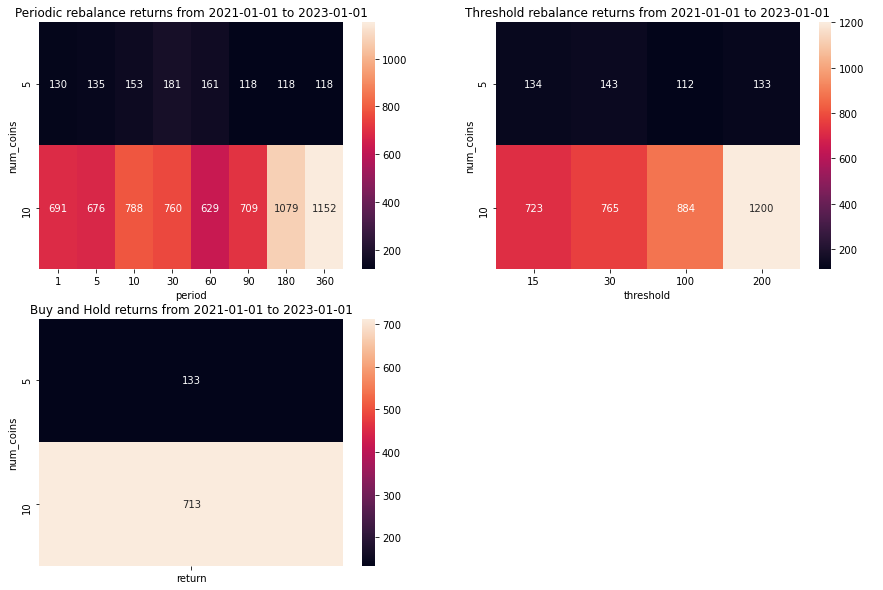

In [13]:
return_heatmaps([5,10], [1,5,10,30,60,90,180,360], [15,30,100,200], coins, prices, from_date='2021-01-01', to_date='2023-01-01')

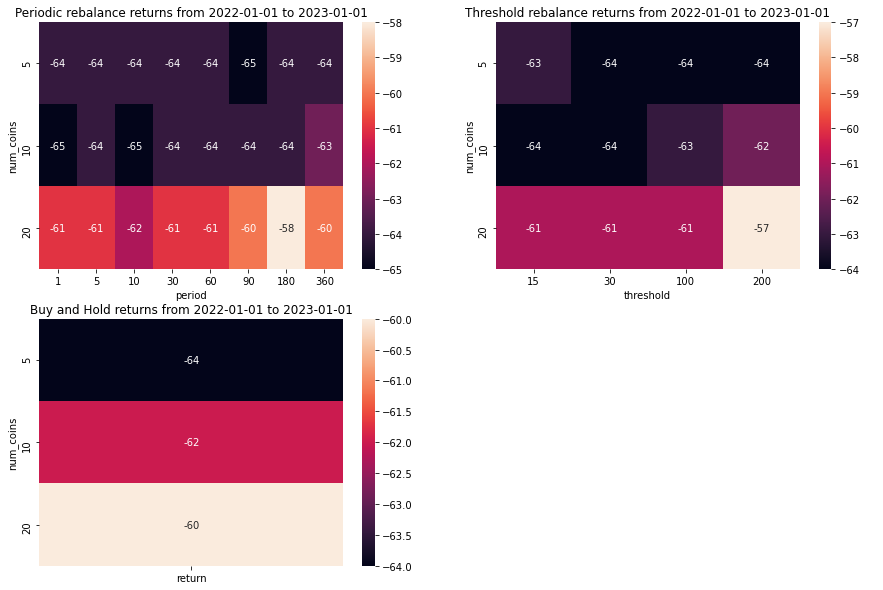

In [14]:
return_heatmaps([5,10,20], [1,5,10,30,60,90,180,360], [15,30,100,200], coins, prices, from_date='2022-01-01', to_date='2023-01-01')

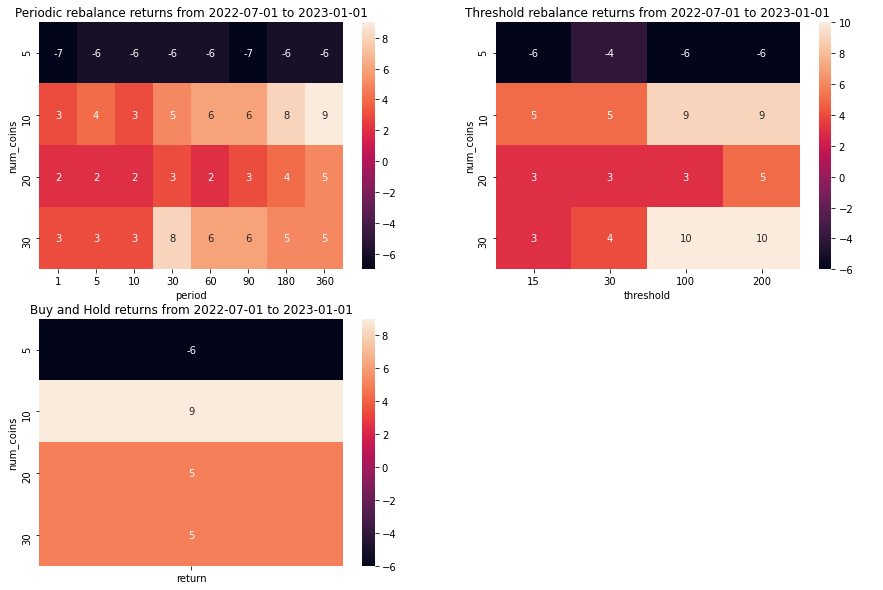

In [15]:
return_heatmaps([5,10,20,30], [1,5,10,30,60,90,180,360], [15,30,100,200], coins, prices, from_date='2022-07-01', to_date='2023-01-01')